<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 사기 탐지 (Credit Card Fraud Detection)

**"전체 데이터의 0.18%밖에 안 되는 사기 거래를 어떻게 찾아낼 것인가?"**
그냥 "모두 정상 거래입니다"라고 예측해도 정확도(Accuracy)는 99.8%가 나옴.
그래서 정확도의 함정을 피하고 **재현율(Recall)**과 F1-Score를 높이는 과정이 필요.

데이터셋 출처: Kaggle [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
sns.set(style='whitegrid', palette='muted')
# 데이터 로드 (캐글에서 creditcard.csv 다운로드 후 업로드 필요)
df = pd.read_csv('creditcard.csv')

In [5]:
# 데이터 탐색
print(df.shape)
print(df['Class'].value_counts())
ratio = df['Class'].value_counts()[1] / len(df) * 100
print(f"사기 거래 비율: {ratio:.4f}%")

(140703, 31)
Class
0.0    140438
1.0       264
Name: count, dtype: int64
사기 거래 비율: 0.1876%


In [7]:
# 4. 데이터 전처리
# Amount와 Time은 스케일이 다르므로 스케일링 필요.
# 특히 Amount는 이상치가 많으므로 RobustScaler 사용 (평균 대신 중앙값 사용)
rob_scaler = RobustScaler()

In [8]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 기존 Time, Amount 삭제하고 스케일링 된 컬럼 추가
df.drop(['Time','Amount'], axis=1, inplace=True)

# 데이터 나누기 (X, y)
X = df.drop('Class', axis=1)
y = df['Class']

In [13]:
nan_mask = y.isna()
X = X[~nan_mask]
y = y[~nan_mask]

#데이터 분할 (stratify=y): 사기 데이터가 워낙 적어서, 그냥 나누면 테스트 셋에 사기 거래가 하나도 안 들어갈 수도 있음.
#stratify=y 옵션을 줘서 학습용/테스트용 데이터 모두 사기 거래 비율을 원본과 똑같이 유지시킴.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE로 데이터 불균형 해결, 학습데이터에만 적용
print("SMOTE 적용 전 훈련 세트 레이블 값 분포: \n", pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 후 훈련 세트 레이블 값 분포: \n", pd.Series(y_train_over).value_counts())
# 이제 사기 거래 데이터와 정상 거래 데이터 개수가 같아짐

SMOTE 적용 전 훈련 세트 레이블 값 분포: 
 Class
0.0    112350
1.0       211
Name: count, dtype: int64
SMOTE 적용 후 훈련 세트 레이블 값 분포: 
 Class
0.0    112350
1.0    112350
Name: count, dtype: int64


**정상 거래와 사기 거래 수가 너무 차이가 많이나서 서로 맞춰줘야 함.**
이 상태로 돌리면 다 정상이라고 찍어도 99.8% 정확도이므로 학습 포기.
smote.fit_resample 코드가 실행되면
211개였던 사기 거래 데이터를 112,350개가 될 때까지 가짜로 생성.

**작동 방식**
사기 데이터 A를 하나 잡음 > A랑 제일 비슷한 사기 데이터 B를 찾음 > A와 B 사이에 점을 찍어서 새로운 데이터 C를 만듦...


In [12]:
# 6. 모델링 및 학습 (Random Forest)
# 시간 관계상 n_estimators는 100으로 설정. 실제론 더 높여도 됨.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_over, y_train_over)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [14]:
y_pred = rf_model.predict(X_test)

In [15]:
def print_score(y_test, y_pred):
    print('오차 행렬(Confusion Matrix):\n', confusion_matrix(y_test, y_pred))
    print('\n분류 보고서(Classification Report):\n', classification_report(y_test, y_pred))
    print(f"정확도: {accuracy_score(y_test, y_pred):.4f}")
    print(f"정밀도: {precision_score(y_test, y_pred):.4f}")
    print(f"재현율(Recall): {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

print_score(y_test, y_pred)

오차 행렬(Confusion Matrix):
 [[28084     4]
 [    4    49]]

분류 보고서(Classification Report):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     28088
         1.0       0.92      0.92      0.92        53

    accuracy                           1.00     28141
   macro avg       0.96      0.96      0.96     28141
weighted avg       1.00      1.00      1.00     28141

정확도: 0.9997
정밀도: 0.9245
재현율(Recall): 0.9245
F1-Score: 0.9245


[128,084 정상 거래 맞춤, 4 개 사기라고 오판단]
[4개가 정상이라고 오판단, 88 사기 맞춤]

[[28084 4], [4 49]]

정상 거래 맞춤: 28,088건 중 28,084건을 맞춤.
정상 고객 2만 8천 명 중 4명한테만 "이거 사기죠?" 하고 실수.
사기 거래 발견: 53건 중 49건을 잡아냄.

재현율(Recall) 0.9245: 전체 사기 거래의 **92.5%**를 탐지.
정밀도(Precision) 0.9245: "사기라고 예측한 것 중 **92.5%**가 진짜 사기.
F1-Score 0.9245: 재현율과 정밀도의 조화평균. 1.0에 가까울수록 우수.


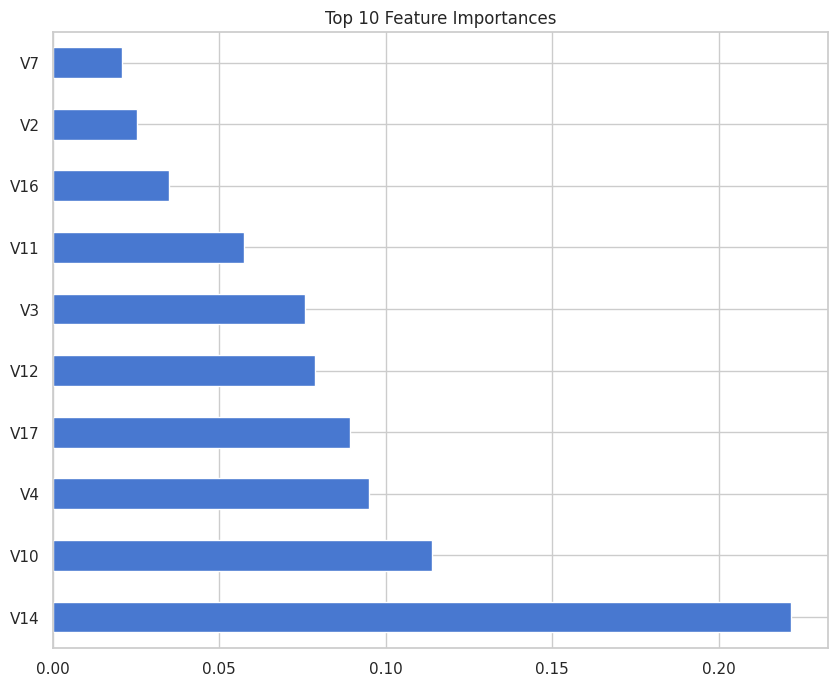

In [16]:
# 8. 중요 변수 시각화 (Feature Importance)
plt.figure(figsize=(10, 8))
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()